In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys, os, re, csv, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("/content/drive/My Drive/labeled_data.csv")

In [4]:
df.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
new = df[df['class']==0].index.tolist()         #drop rows with class 0
df = df.drop(labels = new)
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
df['class'] = df['class'].replace({2:0})
df #clean label=0 ; toxic label = 1

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,0,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


Number of words in each tweet


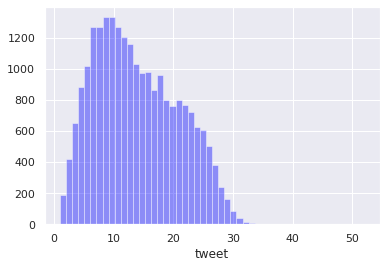

In [7]:
print("Number of words in each tweet")
sns.set(color_codes=True)
comment_len = df.tweet.str.split().str.len()
sns.distplot(comment_len, kde=False, bins=50, color="blue")

Label 0: Clean tweets
Label 1: Toxic tweets


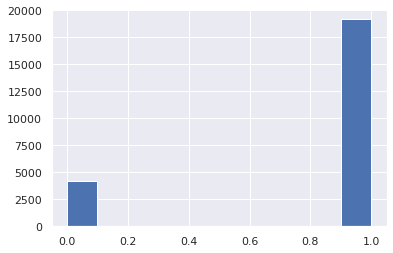

In [8]:
print("Label 0: Clean tweets")
print("Label 1: Toxic tweets")
df['class'].hist()
plt.show()

In [9]:
print("Toxic tweets: ",df['class'].sum(axis=0))
print("Clean tweets: ",len(df)-df['class'].sum(axis=0))

Toxic tweets:  19190
Clean tweets:  4163


In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"] #included these in stopwords
stopwords.extend(other_exclusions)

In [12]:
def preprocess(text):
    corpusTrain = []
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)  #replace lots of whitespace with a single whitespace
    parsed_text = re.sub(giant_url_regex, '', parsed_text) #replace url with ''
    parsed_text = re.sub(mention_regex, '', parsed_text)   #replace @mention with ''
    review = re.sub("[^a-zA-Z]", " ", parsed_text)
    review = review.lower()
    review = review.split(" ")
    review = [word for word in review if word not in set(stopwords)]
    review = (" ").join(review)
    review = re.sub(space_pattern, ' ', review)
    return review

In [13]:
tweets = df.tweet.map(preprocess)
df1 = pd.DataFrame(tweets,columns=['tweet'])

In [14]:
df['tweet']=df1['tweet']
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,woman complain cleaning house amp man always ...
1,1,3,0,3,0,1,boy dats cold tyga dwn bad cuffin dat hoe st ...
2,2,3,0,3,0,1,dawg ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,look like tranny
4,4,6,0,6,0,1,shit hear might true might faker bitch told ya
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,muthaf lie right tl trash mine bible scripture...
24779,25292,3,0,1,2,0,gone broke wrong heart baby drove redneck crazy
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like aint fuck...
24781,25295,6,0,6,0,1,youu got wild bitches tellin lies


In [15]:
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    df.tweet, target_vocab_size=19241)

In [16]:
encoder.subwords[:20]

['bitch_',
 'bitches_',
 'like_',
 'hoes_',
 'pussy_',
 'hoe_',
 'ass_',
 'get_',
 'fuck_',
 'got_',
 'u_',
 'bitch',
 'shit_',
 'nigga_',
 'amp_',
 'trash_',
 'know_',
 'niggas_',
 'one_',
 'love_']

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 15000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 35
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~' '', lower=True, oov_token='OOV')
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19241 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (23353, 35)


In [19]:
Y = pd.get_dummies(df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (23353, 2)


In [20]:
embedding_dim=35

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim, input_length=MAX_SEQUENCE_LENGTH),
  layers.GlobalAveragePooling1D(),
  layers.Dense(5, activation='relu'),
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 35)            771680    
_________________________________________________________________
global_average_pooling1d (Gl (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 180       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
Total params: 771,872
Trainable params: 771,872
Non-trainable params: 0
_________________________________________________________________


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("training: ",X_train.shape,Y_train.shape)
print("validation: ",X_val.shape,Y_val.shape)
print("testing: ",X_test.shape,Y_test.shape)

training:  (16813, 35) (16813, 2)
validation:  (4204, 35) (4204, 2)
testing:  (2336, 35) (2336, 2)


In [22]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=4, validation_data=(X_val,Y_val), validation_steps=20)

Epoch 1/4
526/526 [==============================] - 5s 10ms/step - loss: 0.5333 - accuracy: 0.8159 - val_loss: 0.4882 - val_accuracy: 0.8254
Epoch 2/4
526/526 [==============================] - 5s 10ms/step - loss: 0.4917 - accuracy: 0.8207 - val_loss: 0.4862 - val_accuracy: 0.8254
Epoch 3/4
526/526 [==============================] - 5s 10ms/step - loss: 0.4500 - accuracy: 0.8639 - val_loss: 0.3830 - val_accuracy: 0.9365
Epoch 4/4
526/526 [==============================] - 5s 10ms/step - loss: 0.3578 - accuracy: 0.9629 - val_loss: 0.3630 - val_accuracy: 0.9553


In [23]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

73/73 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.9551
Test set
  Loss: 0.364
  Accuracy: 0.955


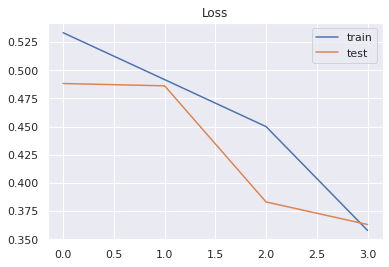

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

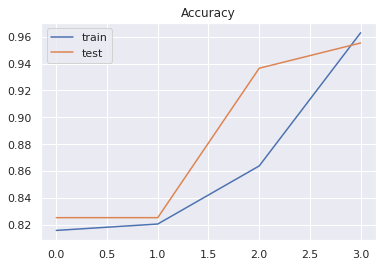

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

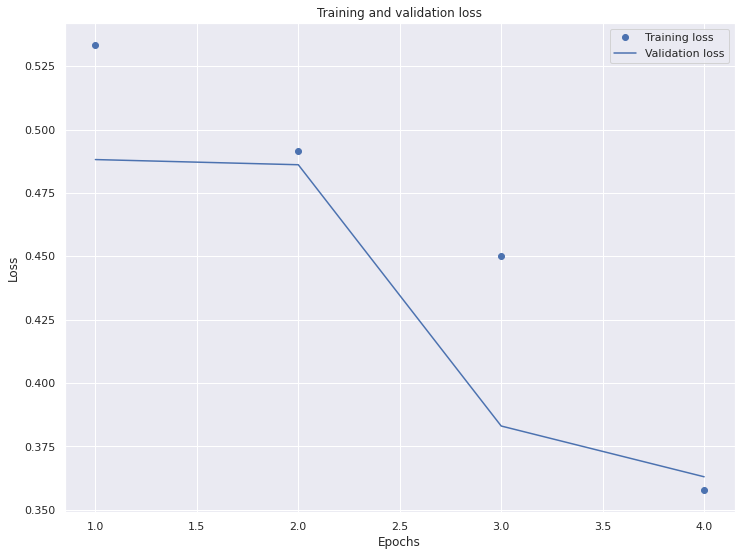

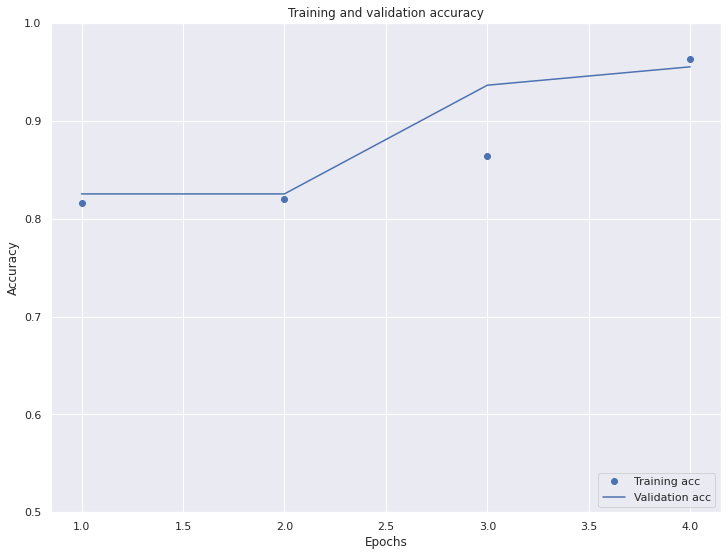

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(22048, 35)


In [28]:
len(encoder.subwords)

21791

In [30]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [31]:
test = pd.read_csv("/content/drive/My Drive/test-Copy1.csv")
test_labels = pd.read_csv("/content/drive/My Drive/test_labels.csv")
test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [32]:
new = test_labels[test_labels['toxic']==-1].index.tolist()                        #removing labels with -1, not valid for testing
test = test.drop(labels = new)
test_labels = test_labels.drop(labels = new)
test['comment_text'] = test['comment_text'].map(preprocess)                       #preprocess comments
test_labels = test_labels.iloc[:,1]
t = test[test['comment_text'].apply(lambda x: len(x.split())>=10)].index.tolist() #selecting tweets with only comments less than 10 words
test = test.drop(labels = t)
test_labels = test_labels.drop(labels = t)
y1 = pd.get_dummies(test_labels)                                                  #one hot encode labels

In [33]:
test.head(5)

,id,comment_text
5,0001ea8717f6de06,thank understanding think highly would revert ...
7,000247e83dcc1211,dear god site horrible
16,000663aff0fffc80,one
19,000844b52dee5f3f,blocked editing wikipedia
22,000968ce11f5ee34,please stop continue vandalize wikipedia homos...


In [34]:
seq = tokenizer.texts_to_sequences(test['comment_text'])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred = (pred > 0.5)
labels = ['0','1']
print(pred, labels[np.argmax(pred)])

[[ True False]
 [ True False]
 [ True False]
 ...
 [False  True]
 [False  True]
 [ True False]] 0


In [35]:
accr1 = model.evaluate(padded,pred)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

635/635 [==============================] - 1s 1ms/step - loss: 0.4795 - accuracy: 1.0000
Test set
  Loss: 0.480
  Accuracy: 1.000


In [38]:
comment = ["fuck you bitches,you assholes",
      "do not do that again please it scares me ",
      "what the fuck is wrong with you",
      "are you mad?",
      "you deserve to be raped",
      "hi how are you?",
      "coward dick",
      "hey nigga i missed you",
      "you motherfucker, what the fuck man!!!",
      "i love my friends",
      "rape is a criminal offence",
      "please dont go. we will continue with this discussion",
      "fuck off",
      "get lost",
      "lets go out for dinner tonight",
      ""]
seq = tokenizer.texts_to_sequences(comment)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred = (pred > 0.5)
labels = ['0','1']
print(pred, labels[np.argmax(pred)])

[[False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]] 1


In [39]:
#saving model
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
